[Chapter 6] Feature Importance Analysis

In [11]:
import numpy as np
import pandas as pd

from sklearn.datasets import make_classification
import statsmodels.discrete.discrete_model as sm

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

import matplotlib.pyplot as plt
import seaborn as sns

motivation - a numerical example

Optimization terminated successfully.
         Current function value: 0.380271
         Iterations 7


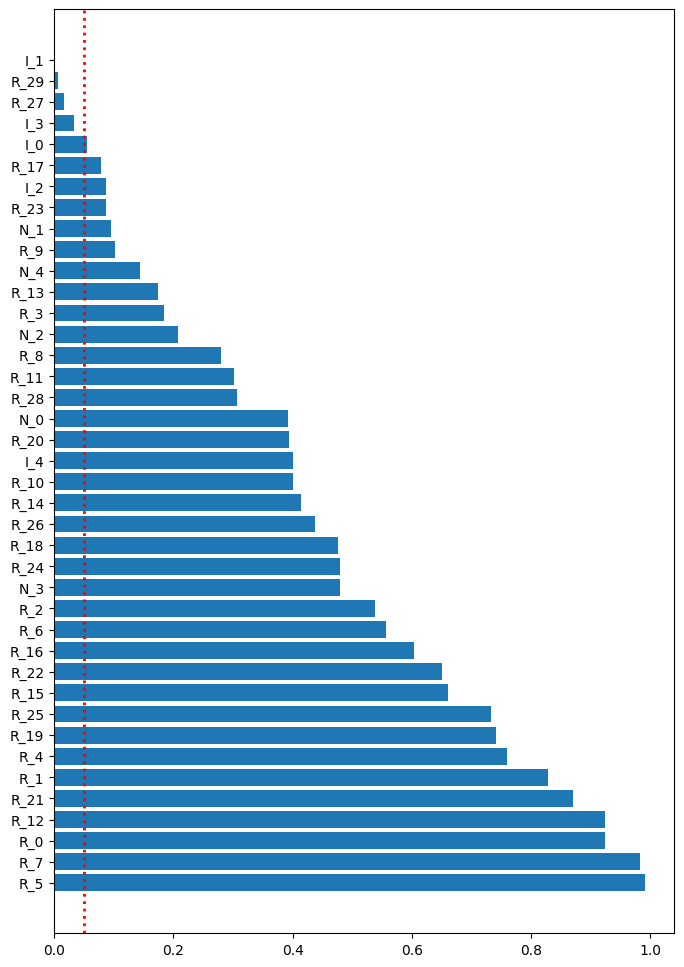

In [ ]:
def getTestData(n_features=100, n_informative=25, n_redundant=25, n_samples=10000, random_state=0, sigmaStd=.0):
    """
    generate a random dataset of informed, redundant, and noise explanatory variables for a classification problem
    """
    np.random.seed(random_state)

    X, y = make_classification(n_samples=n_samples, n_features=n_features-n_redundant,
        n_informative=n_informative, n_redundant=0, shuffle=False, random_state=random_state)
    
    # I_: informative features (used to generate labels)
    cols = ['I_'+str(i) for i in range(n_informative)]
    
    # N_: noise features (that are not used to generate labels)
    cols += ['N_'+str(i) for i in range(n_features-n_informative-n_redundant)]

    # R_: redundant features
    # formed by adding Gaussian noise to a randomly chosen informative feature
    X, y = pd.DataFrame(X, columns=cols), pd.Series(y)
    # randomly choosen informative feature
    i = np.random.choice(range(n_informative), size=n_redundant)
    # the lower the sigmaStd, the greater the substitution effect (cannot discriminate among redundant variables)
    for k, j in enumerate(i):
        X['R_'+str(k)] = X['I_'+str(j)] + np.random.normal(size=X.shape[0])*sigmaStd 
    
    return X, y


# example
X, y = getTestData(40, 5, 30, 10000, sigmaStd=0.1)
ols = sm.Logit(y, X).fit()

# p-vlaues of X
pvals = ols.pvalues.drop('const', errors='ignore').sort_values(ascending=False)
plt.figure(figsize=(8, 12))
plt.barh(pvals.index, pvals.values)
# add a red dotted vertical line at x = 0.05 (significance level)
plt.axvline(x=0.05, color='red', linestyle='dotted', linewidth=2)

feature importance - an ensemble MDI(mean-decrease impurity) method

In [ ]:
def featImpMDI(fit, featName):
    """"
    compute feature importance based on IS mean impuriy reduction
    """
    # dict where 1) keys (i) are integer indices of trees i 
    #            2) values (tree.features_importances_) are feature importance array of each tree
    df0 = {i: tree.feature_importances_ for i, tree in enumerate(fit.estimators_)}
    
    # convert dict df0 to df df0 (with shape of num of trees x num of features)
    # rows correspond to trees i, columns correspond to features, each cell is the importance of that feature in that tree
    df0 = pd.DataFrame.from_dict(df0, orient='index')
    
    # set the columns of the df df0 to the human-readable feature names passed in featName
    df0.columns=featName

    # replaces zeros with NaN
    # when max_features=1 (random select 1 feature at each split), many features may have zero importance in a given tree
    # using NaN excludes these zero values from calculations of mean and standard deviation
    #   avoiding skewing results with zeros (because an absence of split means no importance).
    df0 = df0.replace(0, np.nan) # because max_features=1

    # mean: the mean feature importance across all trees (ignore NaNs)
    # std: the standard deviation of feature importances divided by the square root of number of trees (df0.shape**-.5)
    imp = pd.concat({'mean': df0.mean(), 'std': df0.std()*df0.shape[0]**-.5}, axis=1) #CLT(Central Limit Theorem)

    # normalizes the feature importance DataFrame by dividing every value by the sum of mean importances
    # ensure the sum of all feature mean importances equals 1
    # standard errors are scaled appropriately to preserve relative proportions
    imp /= imp['mean'].sum()

    # return normalized mean feature importances and their standard errors
    return imp

<BarContainer object of 40 artists>

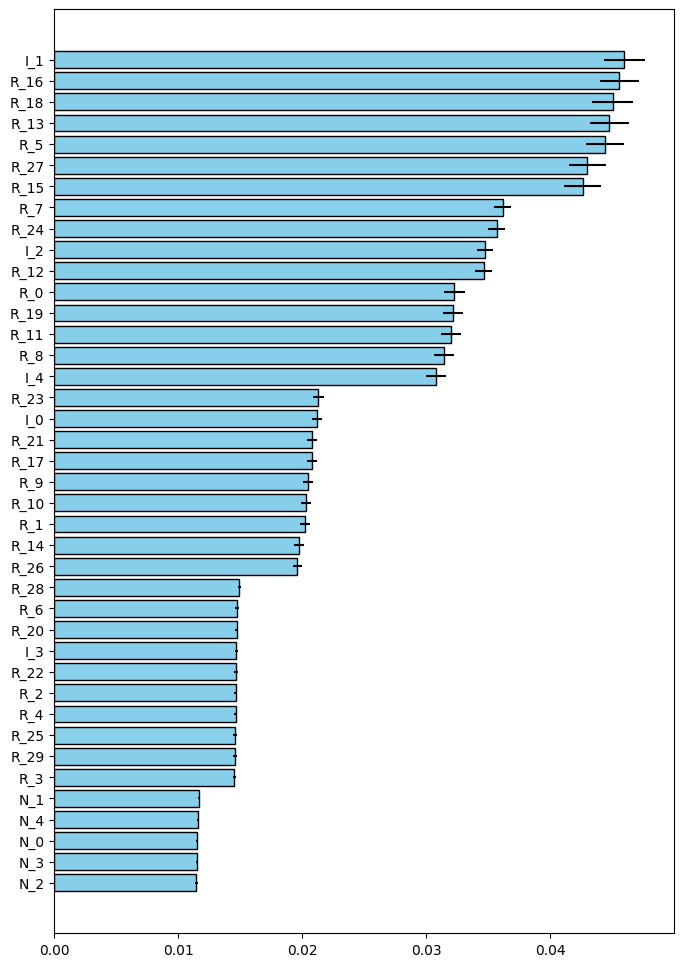

In [ ]:
# test
# generate data
X, y = getTestData(40, 5, 30, 10000, sigmaStd=.1)

# create a Decision Tree classifier with
# criterion='entropy': uses information gain (entropy) to split nodes.
# max_features=1: each split considers only 1 feature randomly (adds randomness).
# class_weight='balanced': automatically adjusts weights inversely proportional to class frequencies (useful if classes are imbalanced).
# min_weight_fraction_leaf=0: no restriction on minimum fraction of samples per leaf.
clf = DecisionTreeClassifier(criterion='entropy', max_features=1,
                             class_weight='balanced', min_weight_fraction_leaf=0)


# wrap the single decision tree clf with BaggingClassifier to create an ensemble of trees trained on bootstrap samples.
#    estimator=clf: base decision tree from above
#    n_estimators=1000: number of base trees in the ensemble (a large forest)
#    max_features=1.: each base estimator uses 100% of features (because 1. means 100%, not the same as single feature — careful difference from DecisionTreeClassifier's param).
#    max_samples=1.: each base estimator is trained on 100% of samples, but with bootstrap sampling by default.
#    oob_score=False: out-of-bag scoring disabled.
# the ensemble adds randomness and reduces overfitting compared to a single tree.
clf = BaggingClassifier(estimator=clf, n_estimators=1000, max_features=1., max_samples=1., oob_score=False)
fit = clf.fit(X, y)

# compute feature importance
imp = featImpMDI(fit, featName=X.columns)

# visualization
imp_sorted = imp.sort_values('mean', ascending=True)
plt.figure(figsize=(8, 12))
plt.barh(imp_sorted.index, imp_sorted['mean'], xerr=imp_sorted['std'], color='skyblue', edgecolor='k')

# after applying the MDI, it works better given all nonnoisy features (I_， R_) are ranked higher than noise features (N_)